In [1]:
import os
import sys
import subprocess

# List of required libraries
required_libraries = [
    "pandas", "numpy", "scikit-learn", "tensorflow", "matplotlib", "seaborn"
]

# Function to install missing libraries
def install_missing_libraries():
    for library in required_libraries:
        try:
            __import__(library)
        except ImportError:
            print(f"Installing missing library: {library}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", library])

# Install missing libraries
install_missing_libraries()

Installing missing library: scikit-learn


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, accuracy_score, f1_score,
    recall_score, precision_score, brier_score_loss
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Define the calculate_metrics function
def calculate_metrics(y_true, y_pred, y_pred_prob):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TP, FN = cm[1,1], cm[1,0]
    FP, TN = cm[0,1], cm[0,0]

    # Calculate Metrics
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity
    FPR = FP / (TN + FP) if (TN + FP) > 0 else 0  # False Positive Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision
    F1_measure = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0  # F1 Score
    Accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0  # Accuracy
    Error_rate = (FP + FN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0  # Error Rate
    BACC = (TPR + TNR) / 2 if (TPR + TNR) > 0 else 0  # Balanced Accuracy
    TSS = TPR - FPR if (TPR + FPR) > 0 else 0  # True Skill Statistic
    # Heidke Skill Score (HSS)
    denominator = ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    numerator = 2 * (TP * TN - FP * FN)
    HSS = numerator / denominator if denominator != 0 else 0

    # Brier Score
    Brier_score = brier_score_loss(y_true, y_pred_prob)

    # Compile metrics into a dictionary
    metrics = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TPR': TPR,
        'TNR': TNR,
        'FPR': FPR,
        'FNR': FNR,
        'Precision': Precision,
        'F1_measure': F1_measure,
        'Accuracy': Accuracy,
        'Error_rate': Error_rate,
        'BACC': BACC,
        'TSS': TSS,
        'HSS': HSS,
        'Brier_score': Brier_score
    }

    return metrics

In [ ]:
df = pd.read_csv('smoking_driking_dataset_Ver01.csv')
print("First few rows of the dataset:")
print(df.head())

# Encode categorical variables
le = LabelEncoder()

# Encode 'sex' column
df['sex'] = le.fit_transform(df['sex'])  # e.g., Male=1, Female=0

# Encode 'DRK_YN' (Drinker or Not)
df['DRK_YN'] = le.fit_transform(df['DRK_YN'])  # Y=1, N=0
print("\nEncoded 'sex' and 'DRK_YN' columns:")
print(df[['sex', 'DRK_YN']].head())

feature_columns = [
    'sex', 'age', 'height', 'weight', 'waistline',
    'sight_left', 'sight_right',
    'hear_left', 'hear_right',
    'SBP', 'DBP', 'BLDS', 'tot_chole',
    'HDL_chole', 'LDL_chole', 'triglyceride',
    'hemoglobin', 'urine_protein', 'serum_creatinine',
    'SGOT_AST', 'SGOT_ALT', 'gamma_GTP',
    'SMK_stat_type_cd'
]

target = 'DRK_YN'

# Extract features and target
X = df[feature_columns]
y = df[target]

# Handles missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Convert to numpy arrays
X_scaled = np.array(X_scaled)
y = np.array(y)

# Initialising Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialising dictionaries to store metrics for each model
metrics_rf = {
    'TP': [], 'TN': [], 'FP': [], 'FN': [],
    'TPR': [], 'TNR': [], 'FPR': [], 'FNR': [],
    'Precision': [], 'F1_measure': [], 'Accuracy': [],
    'Error_rate': [], 'BACC': [], 'TSS': [], 'HSS': [], 'Brier_score': [], 'AUC': []
}

metrics_nb = {
    'TP': [], 'TN': [], 'FP': [], 'FN': [],
    'TPR': [], 'TNR': [], 'FPR': [], 'FNR': [],
    'Precision': [], 'F1_measure': [], 'Accuracy': [],
    'Error_rate': [], 'BACC': [], 'TSS': [], 'HSS': [], 'Brier_score': [], 'AUC': []
}

metrics_lstm = {
    'TP': [], 'TN': [], 'FP': [], 'FN': [],
    'TPR': [], 'TNR': [], 'FPR': [], 'FNR': [],
    'Precision': [], 'F1_measure': [], 'Accuracy': [],
    'Error_rate': [], 'BACC': [], 'TSS': [], 'HSS': [], 'Brier_score': [], 'AUC': []
}
fpr_rf_all = []
tpr_rf_all = []
fpr_nb_all = []
tpr_nb_all = []
fpr_lstm_all = []
tpr_lstm_all = []

First few rows of the dataset:
    sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0  Male   35     170      75       90.0         1.0          1.0        1.0   
1  Male   30     180      80       89.0         0.9          1.2        1.0   
2  Male   40     165      75       91.0         1.2          1.5        1.0   
3  Male   50     175      80       91.0         1.5          1.2        1.0   
4  Male   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1.0  138.0  ...      117.0         104.0        13.8            1.0   

   seru

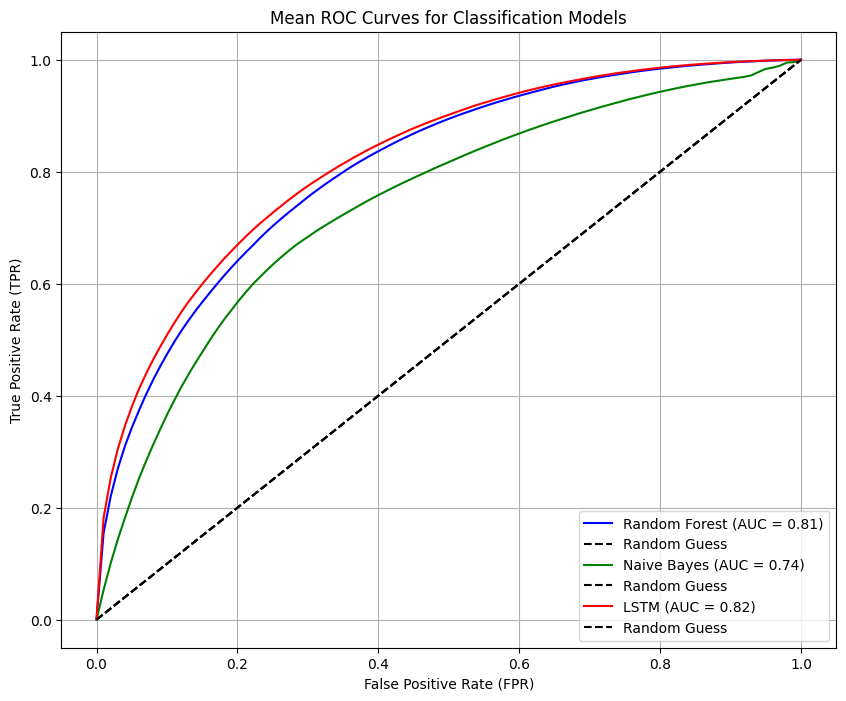

In [ ]:
# Initialising fold counter
fold_number = 1
for train_index, test_index in skf.split(X_scaled, y):
    print(f"\nProcessing Fold {fold_number}")


    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    print(f"Computed Class Weights: {class_weights_dict}")

    ## --- Random Forest Classifier ---
    try:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=5,
            n_jobs=-1,
            verbose=0,
            class_weight='balanced',
            random_state=42
        )
        print("Training Random Forest...")
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        y_proba_rf = rf.predict_proba(X_test)[:, 1]
        metrics_rf_fold = calculate_metrics(y_test, y_pred_rf, y_proba_rf)

        # Computig AUC
        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
        auc_rf = auc(fpr_rf, tpr_rf)
        metrics_rf_fold['AUC'] = auc_rf
        for key in metrics_rf:
            metrics_rf[key].append(metrics_rf_fold[key])
        fpr_rf_all.append(fpr_rf)
        tpr_rf_all.append(tpr_rf)

        print("Random Forest Metrics:", metrics_rf_fold)

    except Exception as e:
        print(f"Random Forest failed on Fold {fold_number}: {e}")

    ## --- Naive Bayes Classifier ---
    try:

        class_counts = np.bincount(y_train)
        total = len(y_train)
        priors = class_counts / total
        print(f"Naive Bayes Priors: {priors}")

        nb = GaussianNB(priors=priors)
        print("Training Naive Bayes...")
        nb.fit(X_train, y_train)
        y_pred_nb = nb.predict(X_test)
        y_proba_nb = nb.predict_proba(X_test)[:, 1]
        metrics_nb_fold = calculate_metrics(y_test, y_pred_nb, y_proba_nb)


        fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
        auc_nb = auc(fpr_nb, tpr_nb)
        metrics_nb_fold['AUC'] = auc_nb
        for key in metrics_nb:
            metrics_nb[key].append(metrics_nb_fold[key])
        fpr_nb_all.append(fpr_nb)
        tpr_nb_all.append(tpr_nb)

        print("Naive Bayes Metrics:", metrics_nb_fold)

    except Exception as e:
        print(f"Naive Bayes failed on Fold {fold_number}: {e}")

    ## --- LSTM Classifier ---
    try:

        X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        lstm_model = create_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
        early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        print("Training LSTM...")
        lstm_model.fit(
            X_train_lstm, y_train,
            epochs=5,
            batch_size=16,
            verbose=1,
            validation_split=0.2,
            callbacks=[early_stop],
            class_weight=class_weights_dict
        )
        y_pred_lstm_prob = lstm_model.predict(X_test_lstm).flatten()
        y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
        metrics_lstm_fold = calculate_metrics(y_test, y_pred_lstm, y_pred_lstm_prob)
        fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm_prob)
        auc_lstm = auc(fpr_lstm, tpr_lstm)
        metrics_lstm_fold['AUC'] = auc_lstm

        for key in metrics_lstm:
            metrics_lstm[key].append(metrics_lstm_fold[key])

        fpr_lstm_all.append(fpr_lstm)
        tpr_lstm_all.append(tpr_lstm)

        print("LSTM Metrics:", metrics_lstm_fold)

    except Exception as e:
        print(f"LSTM failed on Fold {fold_number}: {e}")

    # --- Print Metrics for All Algorithms in Current Fold ---
    print(f"\n----- Metrics for All Algorithms in Iteration {fold_number} -----")
    print(f"{'Metric':<20} {'Random Forest':<15} {'Naive Bayes':<15} {'LSTM':<15}")
    for metric_key, display_name in [
        ('TP', 'TP'),
        ('TN', 'TN'),
        ('FP', 'FP'),
        ('FN', 'FN'),
        ('TPR', 'TPR'),
        ('TNR', 'TNR'),
        ('FPR', 'FPR'),
        ('FNR', 'FNR'),
        ('Precision', 'Precision'),
        ('F1_measure', 'F1_measure'),
        ('Accuracy', 'Acc_by_package_fn'),
        ('Error_rate', 'Error_rate'),
        ('BACC', 'BACC'),
        ('TSS', 'TSS'),
        ('HSS', 'HSS'),
        ('Brier_score', 'Brier_score'),
        ('AUC', 'AUC')
    ]:
        try:
            rf_value = metrics_rf[metric_key][-1]
        except IndexError:
            rf_value = np.nan
        try:
            nb_value = metrics_nb[metric_key][-1]
        except IndexError:
            nb_value = np.nan
        try:
            lstm_value = metrics_lstm[metric_key][-1]
        except IndexError:
            lstm_value = np.nan

        print(f"{display_name:<20} {rf_value:<15.2f} {nb_value:<15.2f} {lstm_value:<15.2f}")


    fold_number += 1

# --- After Cross-Validation: Calculate Average Metrics ---


def average_metrics(metrics):
    avg_metrics = {}
    for key in metrics:
        avg_metrics[key] = np.mean(metrics[key])
    return avg_metrics

avg_metrics_rf = average_metrics(metrics_rf)
avg_metrics_nb = average_metrics(metrics_nb)
avg_metrics_lstm = average_metrics(metrics_lstm)
summary = pd.DataFrame({
    'Metric': ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
               'Precision', 'F1_measure', 'Acc_by_package_fn', 'Error_rate',
               'BACC', 'TSS', 'HSS', 'Brier_score', 'AUC'],
    'Random Forest': [
        avg_metrics_rf['TP'], avg_metrics_rf['TN'], avg_metrics_rf['FP'], avg_metrics_rf['FN'],
        avg_metrics_rf['TPR'], avg_metrics_rf['TNR'], avg_metrics_rf['FPR'], avg_metrics_rf['FNR'],
        avg_metrics_rf['Precision'], avg_metrics_rf['F1_measure'], avg_metrics_rf['Accuracy'], avg_metrics_rf['Error_rate'],
        avg_metrics_rf['BACC'], avg_metrics_rf['TSS'], avg_metrics_rf['HSS'], avg_metrics_rf['Brier_score'], avg_metrics_rf['AUC']
    ],
    'Naive Bayes': [
        avg_metrics_nb['TP'], avg_metrics_nb['TN'], avg_metrics_nb['FP'], avg_metrics_nb['FN'],
        avg_metrics_nb['TPR'], avg_metrics_nb['TNR'], avg_metrics_nb['FPR'], avg_metrics_nb['FNR'],
        avg_metrics_nb['Precision'], avg_metrics_nb['F1_measure'], avg_metrics_nb['Accuracy'], avg_metrics_nb['Error_rate'],
        avg_metrics_nb['BACC'], avg_metrics_nb['TSS'], avg_metrics_nb['HSS'], avg_metrics_nb['Brier_score'], avg_metrics_nb['AUC']
    ],
    'LSTM': [
        avg_metrics_lstm['TP'], avg_metrics_lstm['TN'], avg_metrics_lstm['FP'], avg_metrics_lstm['FN'],
        avg_metrics_lstm['TPR'], avg_metrics_lstm['TNR'], avg_metrics_lstm['FPR'], avg_metrics_lstm['FNR'],
        avg_metrics_lstm['Precision'], avg_metrics_lstm['F1_measure'], avg_metrics_lstm['Accuracy'], avg_metrics_lstm['Error_rate'],
        avg_metrics_lstm['BACC'], avg_metrics_lstm['TSS'], avg_metrics_lstm['HSS'], avg_metrics_lstm['Brier_score'], avg_metrics_lstm['AUC']
    ],
})

# --- Print Average Metrics for Each Algorithm ---
print("\n----- Average Metrics for Each Algorithm Across 10 Folds -----")
print(summary.to_string(index=False, float_format='%.2f'))

# --- Plotting ROC Curves ---

def plot_mean_roc(fpr_list, tpr_list, model_name, color):
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for i in range(len(fpr_list)):
        mean_tpr += np.interp(mean_fpr, fpr_list[i], tpr_list[i])

    mean_tpr /= len(fpr_list)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color=color, label=f'{model_name} (AUC = {mean_auc:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')


plt.figure(figsize=(10, 8))

# Plot ROC for Random Forest
plot_mean_roc(fpr_rf_all, tpr_rf_all, 'Random Forest', 'blue')

# Plot ROC for Naive Bayes
plot_mean_roc(fpr_nb_all, tpr_nb_all, 'Naive Bayes', 'green')

# Plot ROC for LSTM
plot_mean_roc(fpr_lstm_all, tpr_lstm_all, 'LSTM', 'red')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Mean ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
